# Handwritten Digits Recognizer

### Steps

- Load MNIST dataset (handwritten digits) and visualize sample digits
- Write basic preprocessing of dataset: normalize images, split train/test sets.
- Implement first simple feedforward NN
- Train subset (~1-5k images) quick results
- Evaluate accuracy -> even if low
- Upgrade NN to simple CN (1-2 conv layers)
- Train CNN on MNIST -> aim for 95% accuracy
- Log results, plot loss/accuracy curves.
- Finalize CNN -> add droput/batch norm
- Train an ML model (SVM - to compare performance with NN and CNN) 
- save trained model and write simple inference script.
- Optional: create basic CLI to input image and get predicted digits

# Dataset

Content

The MNIST database of handwritten digits has a training set of 60,000 examples, and a test set of 10,000 examples. .

Four files are available:

- train-images-idx3-ubyte.gz: training set images (9912422 bytes)
- train-labels-idx1-ubyte.gz: training set labels (28881 bytes)
- t10k-images-idx3-ubyte.gz: test set images (1648877 bytes)
- t10k-labels-idx1-ubyte.gz: test set labels (4542 bytes)

Goal: To create a CNN that can detect the handwritten digits. In the end I should have a CLI app that I can input an image and output the correct digit.

# First Tasks

- Create reader and plotter for minst dataset
- Visualize the images. 
- Preprocess dataset (Clean, Normalize, etc.)
- Get statistical metrics of dataset and Plot metrics.

IDX format

- Magic Number
- size in dimension 0
- size in dimension 1
- size in dimension 2
- ...
- size in dimension N
- data

magic number is 4 bytes integers with two bytes set as 0 and the other two bytes used to describe:
- basic data type used (3rd byte)
- number of dimensions of the stored array (4th byte)

data types:
- 0x08: unsigned byte 
- 0x09: signed byte 
- 0x0B: short (2 bytes) 
- 0x0C: int (4 bytes) 
- 0x0D: float (4 bytes) 
- 0x0E: double (8 bytes)

4th byte codes the number of dimensions of the vector/matrix:
1 would be for vectors, 2 for two dimension matrices, etc.

Then size of each dimension (4-byte integers, MSB first, big-endian)

data itself is stored in a C array (row-major first) where the index in the last dimension change the fastest



In [13]:
import os
import numpy as np

mnst_dataset = {
    'train_images': 'MNIST_dataset/train-images-idx3-ubyte/train-images-idx3-ubyte',
    'train_labels': 'MNIST_dataset/train-labels-idx1-ubyte/train-labels-idx1-ubyte',
    'test_images': 'MNIST_dataset/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte',
    'test_labels': 'MNIST_dataset/t10k-images-idx1-ubyte/t10k-images-idx1-ubyte',
}

train_images_filepath = os.path.join(os.getcwd(),mnst_dataset.get('train_images'))

with open(train_images_filepath,'rb') as file:
    magic_number = file.read(4) #0 0 (data type) (num of dimensions fo stored arrays)
    dimension_1 = int.from_bytes(file.read(4), byteorder='big', signed=False) # 60000
    dimension_2 = int.from_bytes(file.read(4), byteorder='big', signed=False)# 28
    dimension_3 = int.from_bytes(file.read(4), byteorder='big', signed=False)# 28
    data_np = np.frombuffer(file.read(), dtype=np.uint8) #grayscale (8-bit unsigned integer)
data_np = data_np.reshape(dimension_1,dimension_2,dimension_3) #img pixels (img, row, column)

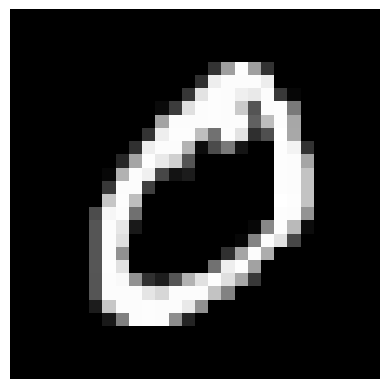

In [14]:
import matplotlib.pyplot as plt
plt.axis('off')
plt.imshow(data_np[1],cmap='gray')

In [1]:
from read_mnist import (
    read_imgages_idx,
    read_labels_idx,
    show_image,
    standardize_data,
    split,
    convert_numpy_to_flatten_tensor,
)
from mnist_neural_net import ImageNeuralNet, ModelTraining
import os
import numpy as np
import torch
from torch import nn
import torch.optim as optim

In [2]:
mnst_dataset = {
    'train_images': 'MNIST_dataset/train-images-idx3-ubyte/train-images-idx3-ubyte',
    'train_labels': 'MNIST_dataset/train-labels-idx1-ubyte/train-labels-idx1-ubyte',
    'test_images': 'MNIST_dataset/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte',
    'test_labels': 'MNIST_dataset/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte',
}

train_images_filepath = os.path.join(os.getcwd(),mnst_dataset.get('train_images'))
train_labels_filepath = os.path.join(os.getcwd(),mnst_dataset.get('train_labels'))
test_images_filepath = os.path.join(os.getcwd(),mnst_dataset.get('test_images'))
test_labels_filepath = os.path.join(os.getcwd(),mnst_dataset.get('test_labels'))

train_images = read_imgages_idx(train_images_filepath)
train_labels = read_labels_idx(train_labels_filepath)
test_images = read_imgages_idx(test_images_filepath)
test_labels = read_labels_idx(test_labels_filepath)


In [3]:
X_train, X_val, y_train, y_val = split(train_images, train_labels, 0.2)

X_train= standardize_data(X_train)
X_val = standardize_data(X_val)

X_train = convert_numpy_to_flatten_tensor(X_train)
X_val = convert_numpy_to_flatten_tensor(X_val)

y_train = torch.tensor(y_train, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

# Need to modify y values (targets) to one-hot encoded 


Standardized with mean: 33.3 and std: 78.55
Standardized with mean: 33.38 and std: 78.63


In [4]:
image_numbers = [0,1,2,3,4,5,6,7,8,9]
image_identity = torch.eye(len(image_numbers))

temp_matrix = {}
for i,image_num in enumerate(image_numbers):
    temp_matrix[image_num] = image_identity[i]

In [5]:
y_train_one_hot= torch.zeros((y_train.shape[0],10))
y_val_one_hot = torch.zeros((y_val.shape[0],10))
for i, y_value in enumerate(y_train):
    y_train_one_hot[i] = temp_matrix.get(y_value.item())
for i, y_value in enumerate(y_val):
    y_val_one_hot[i] = temp_matrix.get(y_value.item())

In [6]:
mps_device = torch.device("mps")
image_length = 28
image_width = 28
image_pixels = image_length * image_width

model = ImageNeuralNet(image_pixels).to(mps_device)
optimizer = optim.Adam(model.parameters(), lr=0.003)
loss_function = nn.CrossEntropyLoss()

feedforward_model = ModelTraining(model,optimizer,loss_function)


In [7]:
training_set = (X_train,y_train_one_hot)
val_set = (X_val, y_val_one_hot) 

epochs = 10
batch_size = 32
feedforward_model.train_loop(training_set, val_set, epochs, batch_size)

Epoch 1
Train Loss: 1.0087424995501837
Val Loss: 0.724542191028595

Epoch 2
Train Loss: 0.6838022789259751
Val Loss: 0.6815258096853892

Epoch 3
Train Loss: 0.6466103461285432
Val Loss: 0.6590304409662883

Epoch 4
Train Loss: 0.6244886225561301
Val Loss: 0.6472121622562409

Epoch 5
Train Loss: 0.6098676435550054
Val Loss: 0.6330465390284856

Epoch 6
Train Loss: 0.5969499126474063
Val Loss: 0.6181243799130122

Epoch 7
Train Loss: 0.5859315565129121
Val Loss: 0.6049829322894414

Epoch 8
Train Loss: 0.5749045993288358
Val Loss: 0.586099206964175

Epoch 9
Train Loss: 0.565542520225048
Val Loss: 0.5809111231565476

Epoch 10
Train Loss: 0.5463218189974626
Val Loss: 0.5615733327865601



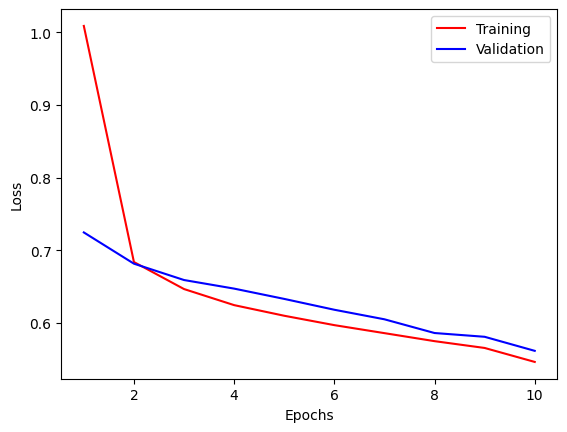

In [8]:
feedforward_model.plot_train_eval_figure()

# To-Do:
- Try regularization (0,1) data not mean.
- Add parameter details to plots
- Include save method
- Add parameter details to saved file for distinguishing
- Clean code, more efficient, optimized.
- Add doc strings.
- Try different architecture and lr. Then save does models and compare.